# Contents
* EDA
* Statistical modeling
* ML models
* RNN : LSTMs, GNUs,
* Encoder Decoder (With Attention)

# Load libraries

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


In [3]:
sample_submission = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sales_eval = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

sales.head(), calendar.head()

(                              id        item_id    dept_id   cat_id store_id  \
 0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
 1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
 2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
 3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
 4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
 
   state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
 0       CA    0    0    0    0  ...       1       3       0       1       1   
 1       CA    0    0    0    0  ...       0       0       0       0       0   
 2       CA    0    0    0    0  ...       2       1       2       1       1   
 3       CA    0    0    0    0  ...       1       0       5       4       1   
 4       CA    0    0    0    0  ...       2       1       1       0       1   
 
    d_1909  d_1910  d_1911  d_

# EDA
Let's understand the data.

In [4]:
sales.describe(include=['O'])

,id,item_id,dept_id,cat_id,store_id,state_id
count,30490,30490,30490,30490,30490,30490
unique,30490,3049,7,3,10,3
top,HOBBIES_2_044_TX_3_validation,HOBBIES_1_287,FOODS_3,FOODS,WI_2,CA
freq,1,10,8230,14370,3049,12196


In [5]:
sales_eval.describe(include=['O'])

,id,item_id,dept_id,cat_id,store_id,state_id
count,30490,30490,30490,30490,30490,30490
unique,30490,3049,7,3,10,3
top,HOUSEHOLD_2_254_TX_2_evaluation,HOBBIES_1_287,FOODS_3,FOODS,WI_2,CA
freq,1,10,8230,14370,3049,12196


In [6]:
print('Categories:\n',sales.cat_id.value_counts())
print('\n\nItems:\n', sales.item_id.value_counts())
print('\n\nStores:\n', sales.store_id.value_counts())
print('\n\nStates:\n', sales.state_id.value_counts())

Categories:
 FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64


Items:
 HOBBIES_1_287      10
FOODS_3_386        10
HOUSEHOLD_1_118    10
FOODS_3_303        10
HOUSEHOLD_1_144    10
                   ..
FOODS_3_581        10
HOUSEHOLD_2_083    10
FOODS_2_302        10
FOODS_3_115        10
HOUSEHOLD_2_385    10
Name: item_id, Length: 3049, dtype: int64


Stores:
 WI_2    3049
TX_2    3049
CA_3    3049
TX_1    3049
CA_4    3049
WI_3    3049
CA_2    3049
CA_1    3049
TX_3    3049
WI_1    3049
Name: store_id, dtype: int64


States:
 CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64


* There are 3049 items across 10 stores spread between 3 states.
* Sales for each item from each store is tabulated in the same row. It'd be good to analyze the seasonality of the product across stores.
* The submission file expects the forecasting for each item in both datasets (training and eval) in each store for the next 28 days. Both datasets contains 30490 items each. So, the submission file should contain a total of 60980 rows in total one for each item.

In [7]:
print('Sales shape:',sales.shape)
print('Sales eval shape:', sales_eval.shape)

Sales shape: (30490, 1919)
Sales eval shape: (30490, 1947)


In [8]:
ids = sorted(list(set(sales_eval['id'])))
d_cols = [c for c in sales_eval.columns if 'd_' in c]
x_1 = sales_eval.loc[sales_eval['id'] == ids[2]].set_index('id')[d_cols].values[0]
x_2 = sales_eval.loc[sales_eval['id'] == ids[1]].set_index('id')[d_cols].values[0]
x_3 = sales_eval.loc[sales_eval['id'] == ids[17]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

In [9]:
sales.loc[sales['id']==ids[0]]
ids

['FOODS_1_001_CA_1_evaluation',
 'FOODS_1_001_CA_2_evaluation',
 'FOODS_1_001_CA_3_evaluation',
 'FOODS_1_001_CA_4_evaluation',
 'FOODS_1_001_TX_1_evaluation',
 'FOODS_1_001_TX_2_evaluation',
 'FOODS_1_001_TX_3_evaluation',
 'FOODS_1_001_WI_1_evaluation',
 'FOODS_1_001_WI_2_evaluation',
 'FOODS_1_001_WI_3_evaluation',
 'FOODS_1_002_CA_1_evaluation',
 'FOODS_1_002_CA_2_evaluation',
 'FOODS_1_002_CA_3_evaluation',
 'FOODS_1_002_CA_4_evaluation',
 'FOODS_1_002_TX_1_evaluation',
 'FOODS_1_002_TX_2_evaluation',
 'FOODS_1_002_TX_3_evaluation',
 'FOODS_1_002_WI_1_evaluation',
 'FOODS_1_002_WI_2_evaluation',
 'FOODS_1_002_WI_3_evaluation',
 'FOODS_1_003_CA_1_evaluation',
 'FOODS_1_003_CA_2_evaluation',
 'FOODS_1_003_CA_3_evaluation',
 'FOODS_1_003_CA_4_evaluation',
 'FOODS_1_003_TX_1_evaluation',
 'FOODS_1_003_TX_2_evaluation',
 'FOODS_1_003_TX_3_evaluation',
 'FOODS_1_003_WI_1_evaluation',
 'FOODS_1_003_WI_2_evaluation',
 'FOODS_1_003_WI_3_evaluation',
 'FOODS_1_004_CA_1_evaluation',
 'FOODS_

In [10]:
ids = sorted(list(set(sales['id'])))
d_cols = [c for c in sales.columns if 'd_' in c]
x_1 = sales.loc[sales['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales.loc[sales['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales.loc[sales['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                        mode='lines+markers', name="First sample",
                            marker=dict(color="mediumseagreen")),
                         row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

In [11]:
sales.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)

In [12]:
len(x_1), len(x_2), len(x_3)

(90, 100, 100)

In [13]:
x_1.shape, x_2.shape, x_3.shape

((90,), (100,), (100,))

In [14]:
import pywt
from statsmodels.robust import mad
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)

In [15]:
y_w1, y_w2, y_w3

(array([0.65694254, 0.87055228, 1.11690344, 1.28118827, 1.35613608,
        1.38804881, 1.34388828, 1.31080632, 1.29159497, 1.21314854,
        1.09248139, 1.03073006, 1.02761361, 1.04551692, 1.10958324,
        1.14153489, 1.13708183, 1.1561442 , 1.18162422, 1.2257518 ,
        1.29665874, 1.37674615, 1.47148727, 1.58899694, 1.72866542,
        1.89198863, 2.08130271, 2.20878309, 2.26711414, 2.30010478,
        2.28354397, 2.26908429, 2.26019624, 2.2099173 , 2.12877988,
        2.05461253, 1.98429157, 1.90619917, 1.82846225, 1.71625932,
        1.56723597, 1.40471877, 1.2203642 , 1.08515308, 1.00807329,
        0.94927063, 0.92931196, 0.91220399, 0.89519679, 0.91464658,
        0.9635687 , 0.97115797, 0.93622271, 0.8884845 , 0.81012414,
        0.75238489, 0.71866751, 0.66865478, 0.61370248, 0.58467499,
        0.58006375, 0.59336468, 0.63223503, 0.66910758, 0.70361664,
        0.75618241, 0.82131136, 0.87608052, 0.92071311, 0.96245867,
        0.99550272, 1.03897882, 1.0935857 , 1.14

In [16]:

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
fig.show()

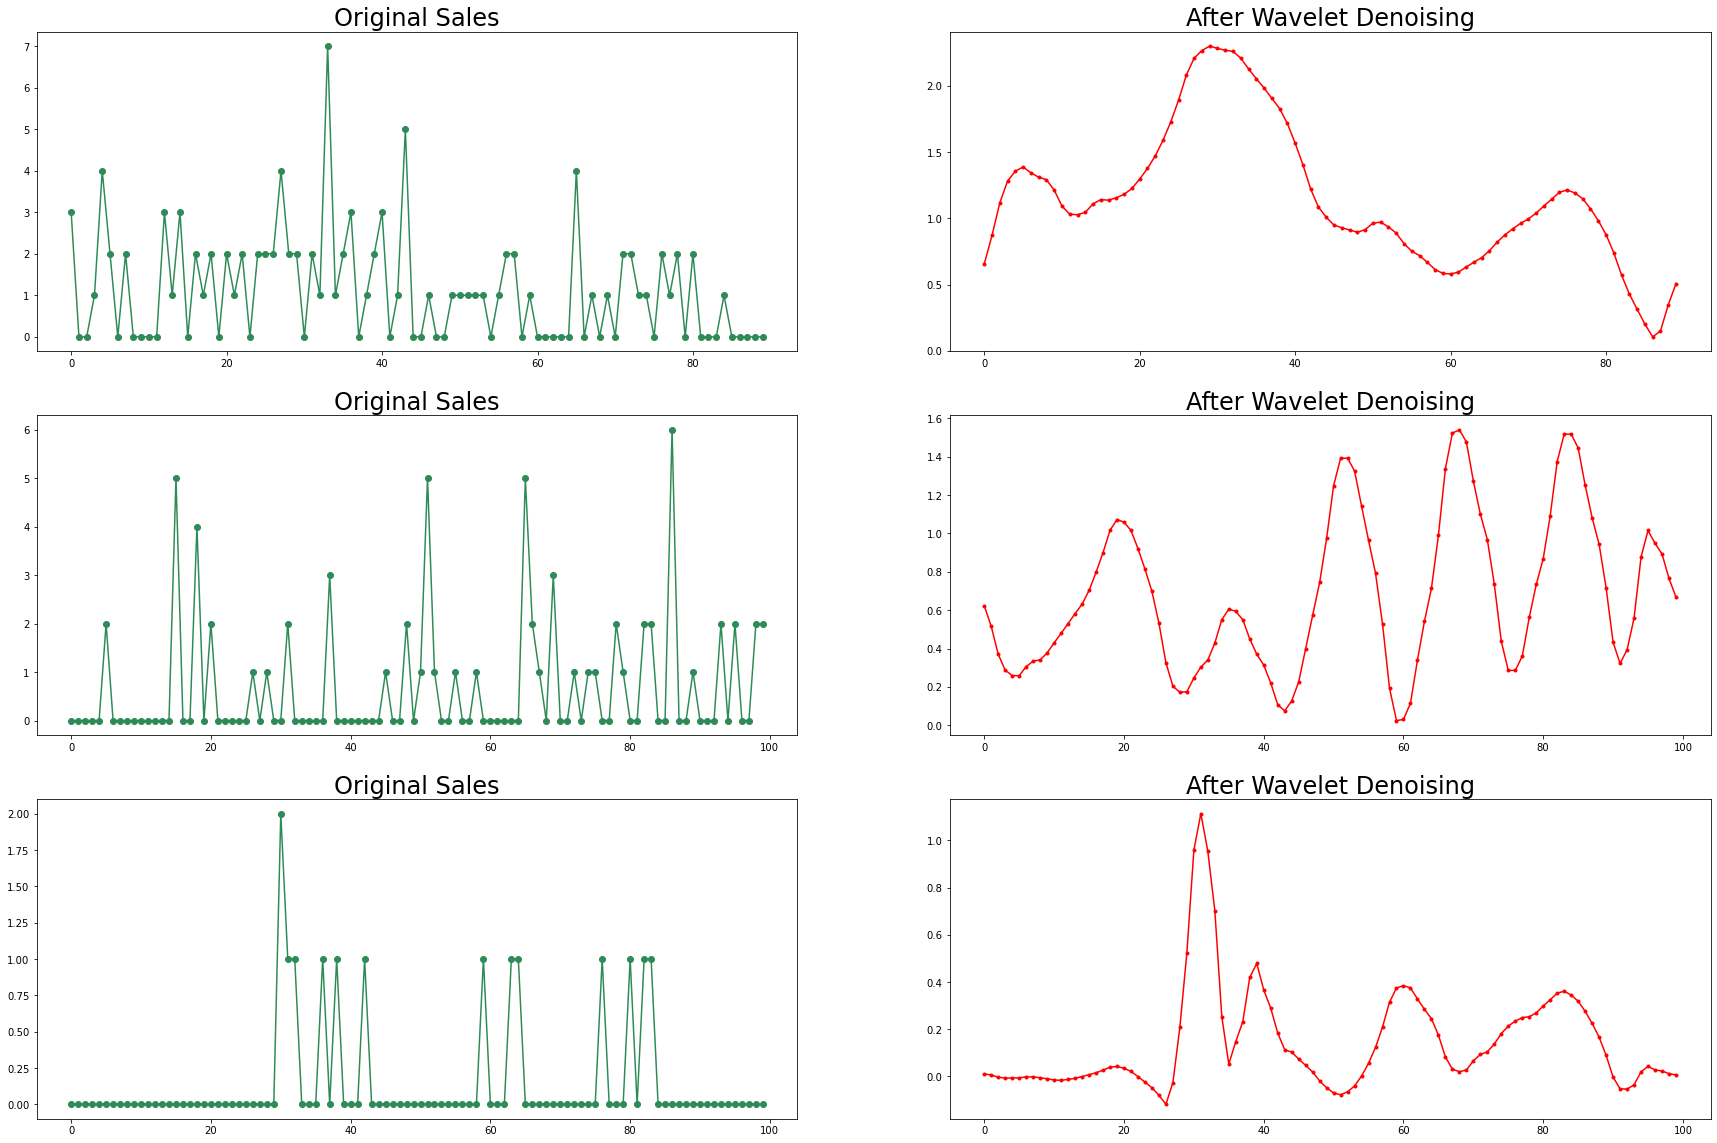

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

In [18]:
def average_smoothing(signal, kernel_size=3, stride=1):
    sample = []
    start = 0
    end = kernel_size
    while end <= len(signal):
        start = start + stride
        end = end + stride
        sample.extend(np.ones(end - start)*np.mean(signal[start:end]))
    return np.array(sample)

In [19]:
y_a1 = average_smoothing(x_1)
y_a2 = average_smoothing(x_2)
y_a3 = average_smoothing(x_3)

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="lightskyblue"), showlegend=False,
               name="Original sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_a1, mode='lines', marker=dict(color="navy"), showlegend=False,
               name="Denoised sales"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_a2, mode='lines', marker=dict(color="indigo"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="mediumaquamarine"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_a3, mode='lines', marker=dict(color="darkgreen"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) signals")
fig.show()

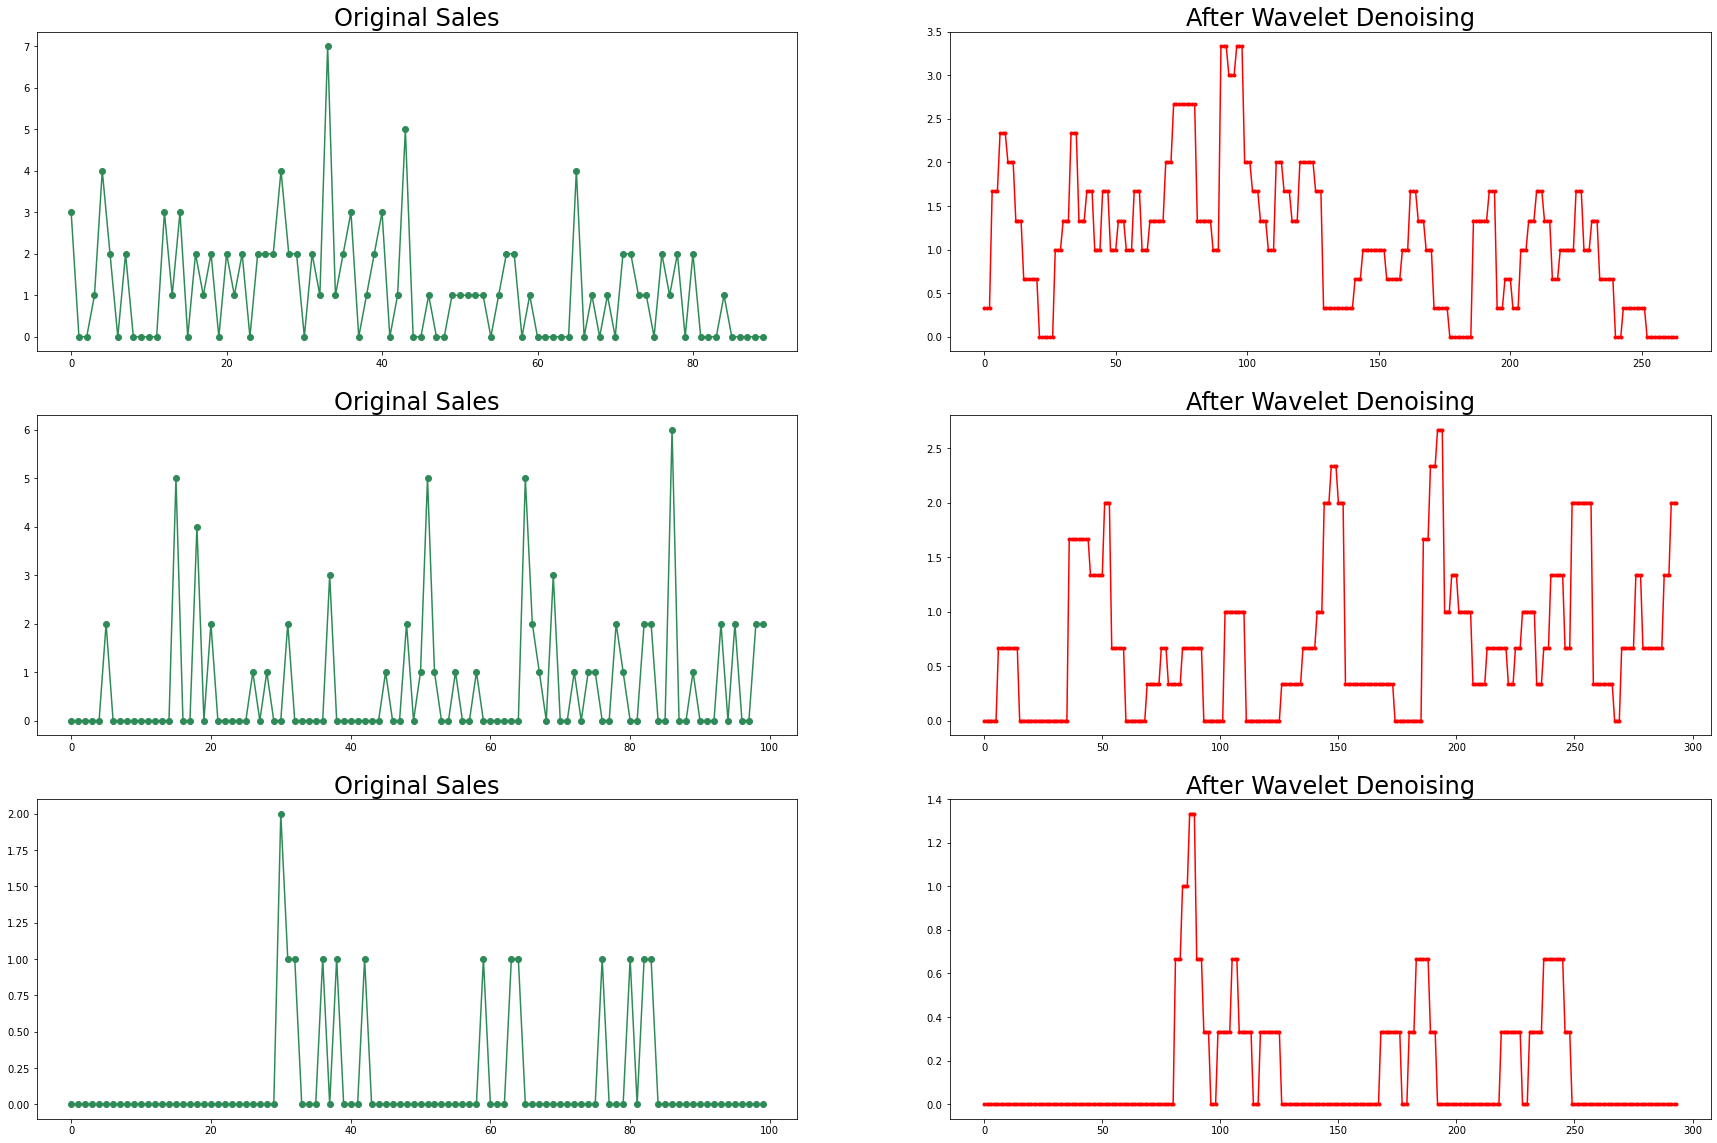

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o') 
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_a1, color='red', marker='.') 
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o') 
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_a2, color='red', marker='.') 
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o') 
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_a3, color='red', marker='.') 
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()

In [21]:
past_sales = sales.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

store_list = sell_prices['store_id'].unique()
means = []
fig = go.Figure()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    data = past_sales[store_items].sum(axis=1).rolling(90).mean()
    means.append(np.mean(past_sales[store_items].sum(axis=1)))
    fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (per store)")

Train Validation split

In [22]:
train_dataset = sales[d_cols[-100:-30]]
val_dataset = sales[d_cols[-30:]]

In [23]:
train_dataset.loc[0]

d_1814    0
d_1815    0
d_1816    0
d_1817    2
d_1818    1
         ..
d_1879    1
d_1880    2
d_1881    2
d_1882    0
d_1883    1
Name: 0, Length: 70, dtype: int64

In [24]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

# Naive approach
Simply forecasts next days prediction same as current day data

In [25]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(train_dataset[train_dataset.columns[-1]].values)
    else:
        predictions.append(val_dataset[val_dataset.columns[i-1]].values)
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_naive = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [26]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Naive approach")
fig.show()

# Moving average

In [27]:
predictions = []
for i in range(len(val_dataset.columns)):
    if i == 0:
        predictions.append(np.mean(train_dataset[train_dataset.columns[-30:]].values, axis=1))
    if i < 31 and i > 0:
        predictions.append(0.5 * (np.mean(train_dataset[train_dataset.columns[-30+i:]].values, axis=1) + \
                                  np.mean(predictions[:i], axis=0)))
    if i > 31:
        predictions.append(np.mean([predictions[:i]], axis=1))
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))
error_avg = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [28]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Moving average")
fig.show()

ARIMA

In [31]:
from tqdm.notebook import tqdm as tqdm
import statsmodels.api as sm
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(0, 1, 1, 7)).fit()
    predictions.append(fit.forecast(30))
predictions = np.array(predictions).reshape((-1, 30))
error_arima = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



In [33]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="ARIMA")
fig.show()

Prophet

In [38]:
from fbprophet import Prophet
dates = ["2007-12-" + str(i) for i in range(1, 31)]
predictions = []
for row in tqdm(train_dataset[train_dataset.columns[-30:]].values[:3]):
    df = pd.DataFrame(np.transpose([dates, row]))
    df.columns = ["ds", "y"]
    model = Prophet(daily_seasonality=True)
    model.fit(df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)["yhat"].loc[30:].values
    predictions.append(forecast)
predictions = np.array(predictions).reshape((-1, 30))
error_prophet = np.linalg.norm(predictions[:3] - val_dataset.values[:3])/len(predictions[0])

In [39]:
pred_1 = predictions[0]
pred_2 = predictions[1]
pred_3 = predictions[2]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"),
               name="Train"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"),
               name="Val"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_1, mode='lines', marker=dict(color="seagreen"),
               name="Pred"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_2, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=pred_3, mode='lines', marker=dict(color="seagreen"), showlegend=False,
               name="Denoised signal"),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Prophet")
fig.show()

In [42]:
days = range(1, 1913 + 1)
time_series_columns = [f'd_{i}' for i in days]
time_series_data = sales[time_series_columns]
forecast = pd.DataFrame(time_series_data.iloc[:, -28:].mean(axis=1))
forecast = pd.concat([forecast] * 28, axis=1)
forecast.columns = [f'F{i}' for i in range(1, forecast.shape[1] + 1)]
validation_ids = sales['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
ids = np.concatenate([validation_ids, evaluation_ids])
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast] * 2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('submission.csv', index=False)

Model wise loss

In [45]:
error = [error_naive, error_arima, error_prophet]
names = ["Naive approach", "ARIMA", "Prophet"]
df = pd.DataFrame(np.transpose([error, names]))
df.columns = ["RMSE Loss", "Model"]
px.bar(df, y="RMSE Loss", x="Model", color="Model", title="RMSE Loss vs. Model")